## Module Imports

In [16]:
from treetime.utils import parse_dates
from treetime import TreeTime
from treetime import wrappers

from Bio import Phylo
import random

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm

from datetime import datetime
import pandas as pd

## Setup input file paths

In [2]:
meta_path = "../Assembly_Modern/nextstrain/metadata_nextstrain_geocode_state.tsv"
tree_path = "../Assembly_Modern/iqtree/iqtree.core-filter0_bootstrap.treefile"
aln_path = "../Assembly_Modern/snippy_multi/snippy-core.full_CHROM.filter0.fasta"

## Constants and Variables

In [3]:
NUM_SAMPLE_REMOVE = 20
NUM_ITER = 1
NO_DATA_CHAR = "?"
VAL_DATE_REMOVE = [1894.00, 2019.00]

random.seed(1753143)

## Parse the dates

In [4]:
dates = parse_dates(date_file=meta_path, date_col="BioSampleCollectionDate")


Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'BioSampleCollectionDate' as date.


## Parse the tree

In [5]:
tree = Phylo.read(tree_path, "newick")
tree_tip_names = [t.name for t in tree.get_terminals()]

## Tip-Dating: Randomly select the tip samples

In [6]:
dict_sample_remove = {}

for i in range(0,NUM_SAMPLE_REMOVE):
    
    # Retrieve tip name and val (date)
    tip = random.choice(list(dates.keys()))
    tip_val = dates[tip]
    
    # Check that it is a float (and not a list range)
    # And that it is actually in the input tree
    while type(tip_val) != type(0.1) or tip not in tree_tip_names:
        tip = random.choice(list(dates.keys()))
        tip_val = dates[tip] 
        
    dict_sample_remove[tip] = tip_val
    
    # Remove the metadata from the dates object
    dates[tip] = VAL_DATE_REMOVE

## Node-Dating: identify the internal nodes

In [7]:
## Black Death Node

## Root Node

## Treetime relaxed clock analysis

In [8]:
tt_relaxed = TreeTime(tree = tree_path,
                      aln = aln_path,
                      verbose = 4,
                      dates = dates)


0.00	-TreeAnc: set-up

65.11	-SequenceData: loaded alignment.

65.11	-SeqData: making compressed alignment...

170.32	-SequenceData: constructed compressed alignment...
190.55	--ClockTree: Setting precision to level 2

190.57	-ClockTree._assign_dates: assigned date contraints to 476 out of 476
      	 tips.


In [9]:
tt_relaxed.run(#branch_length_mode = "input", # Don't optimize branch lengths
               branch_length_mode = "joint",
               n_iqd=3,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":1.0, "coupling":0.0},
               # Slack: Maximum change in substitution rate between parent and child nodes
               # Coupling: Maximum difference in substitution rates in sibling nodes
               max_iter=3,
               Tc="skyline",
               use_covariation=False, # covariation is only for strict molecular clock
               time_marginal=True, # Enable final round for error bar estimation,
               verbose=4,
              )


190.57	-TreeAnc.optimize_tree: sequences...

190.57	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

190.57	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences
      	of tips at positions with AMBIGUOUS bases. This resulted in unexpected
      	behavior is some cases and is no longer done by default. If you want to
      	replace those ambiguous sites with their most likely state, rerun with
      	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
190.57	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
190.57	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
191.90	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
      	   likelihood sequences...
191.94	---TreeAnc._ml_anc_joint: ...done
191.95	--TreeAnc.infer_gtr: counting mutations...
198.87	---TreeAnc.infer_gtr: counting mutations...done

198.87	-GTR: with alphabet: ['A', 'C', 'G', 'T', '-']
198.87	--GTR: ambiguous character: N
198.87	-

223.65	--optimized Tc to 0.000413
relaxed_clock {'slack': 1.0, 'coupling': 0.0}
223.84	--TreeTime.relaxed_clock: slack=1.000000, coupling=0.000000

223.85	-ClockTree: Maximum likelihood tree optimization with temporal
      	 constraints
223.85	--ClockTree.init_date_constraints...
223.85	---ClockTree.init_date_constraints: Initializing branch length
      	   interpolation objects...
229.80	--ClockTree.date2dist: Setting new molecular clock. rate=3.095e-08,
      	  R^2=0.0020
229.81	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
229.81	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
229.81	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
 

313.41	--ClockTree.date2dist: Setting new molecular clock. rate=3.095e-08,
      	  R^2=0.0020
313.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
313.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
313.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
313.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
313.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
313.43	---

'success'

## Compare actual with estimated

In [10]:
dict_sample_estimate = {}
list_ci_contain_sample_date = []

# Get the terminal nodes from the estimated relaxed clock model
for t in tt_relaxed.tree.get_terminals():
    if t.name in dict_sample_remove:
        conf = tt_relaxed.get_max_posterior_region(t, fraction=0.9)
        lower_conf = conf[0]
        upper_conf = conf[1]
        sample_date = dict_sample_remove[t.name]
        dict_sample_estimate[t.name] = {'sample_date': sample_date,
                                        'estimate_date': t.numdate,
                                        'lower_conf': lower_conf,
                                        'upper_conf': upper_conf
                                       }
        
        if lower_conf <= sample_date and upper_conf >= sample_date:
            list_ci_contain_sample_date.append(t.name)
        
perc_ci_contain_sample_date = (len(list_ci_contain_sample_date) / len(dict_sample_estimate)) * 100
  

#for sample in dict_sample_estimate:
#    print(sample)
#    print("\t", dict_sample_estimate[sample]['sample_date'])
#    print("\t", dict_sample_estimate[sample]['estimate_date'])
#    print("\t", dict_sample_estimate[sample]['lower_conf'])
#    print("\t", dict_sample_estimate[sample]['upper_conf'])


## Visualize differences

### Plot data

In [11]:
# Scatter plot of actual sampling dates

list_sample_name = list(dict_sample_estimate.keys())
list_sample_date = [dict_sample_estimate[sample]['sample_date'] for sample in dict_sample_estimate]
list_estimate_date = [dict_sample_estimate[sample]['estimate_date'] for sample in dict_sample_estimate]
list_lower_conf = [dict_sample_estimate[sample]['lower_conf'] for sample in dict_sample_estimate]
list_upper_conf = [dict_sample_estimate[sample]['upper_conf'] for sample in dict_sample_estimate]

# Lists for error bar calculations
list_lower_diff = []
list_upper_diff = []

zip_estimate_lower = zip(list_estimate_date, list_lower_conf)
for list1_i, list2_i in zip_estimate_lower:
    list_lower_diff.append(list1_i-list2_i)
    
zip_estimate_upper = zip(list_upper_conf, list_estimate_date)
for list1_i, list2_i in zip_estimate_upper:
    list_upper_diff.append(list1_i-list2_i)

    

### Plotting

/home/ktmeaton/miniconda3/envs/nextstrain-8.0.0/lib/python3.6/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


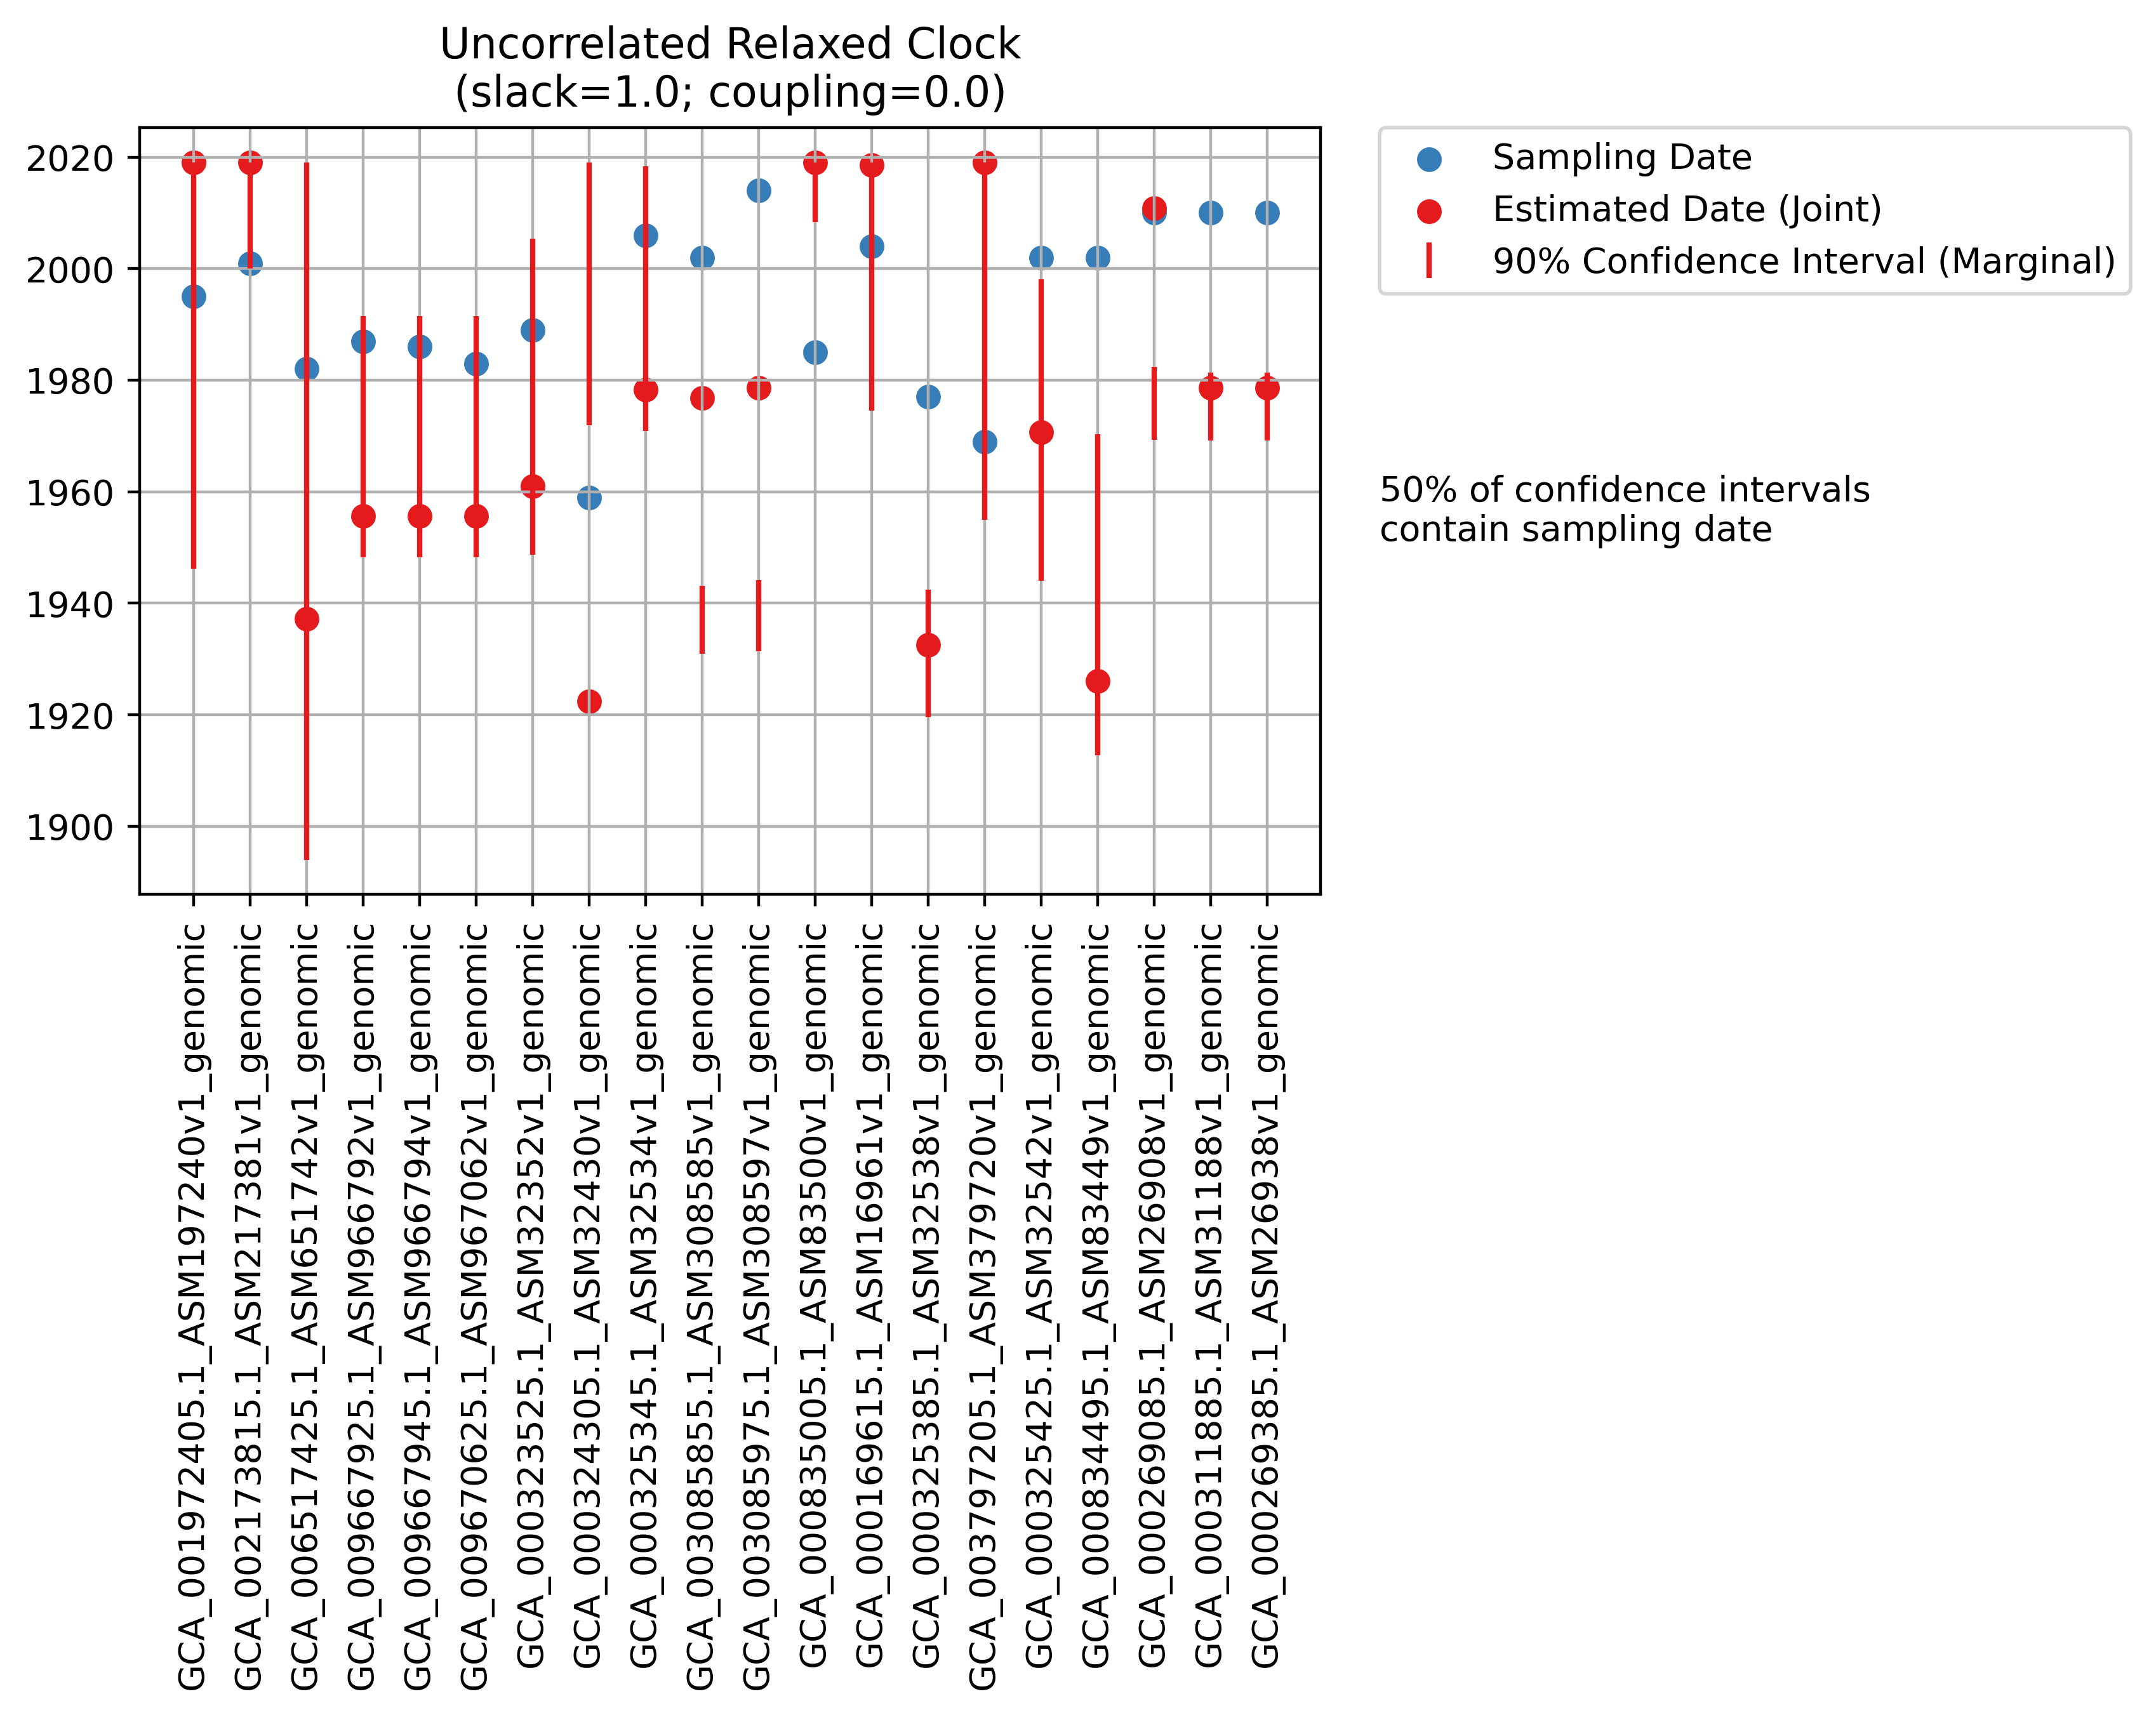

In [12]:
plt.figure(dpi=400)
ax = plt.subplot()
#print(fig)

# 90% Confidence Interval
plt.errorbar(
    x=list_sample_name,
    y=list_estimate_date,
    yerr=[list_lower_diff, list_upper_diff],
    linestyle='',
    c="#e41a1c",
    label="90% Confidence Interval (Marginal)",
)

# Sampling date scatter plot
scatter_sample = plt.scatter(x=list_sample_name, y=list_sample_date, c="#377eb8", label = "Sampling Date")

# Estimated date scatter plot
plt.scatter(x=list_sample_name, y=list_estimate_date, c="#e41a1c", label = "Estimated Date (Joint)", )

perc_string = "{0:.0f}% of confidence intervals \ncontain sampling date".format(perc_ci_contain_sample_date)
                                                                                
# Add text
plt.text(1.05, 0.5, 
         perc_string, 
         horizontalalignment='left', 
         verticalalignment='center', 
         transform=ax.transAxes)

# Formatting
plt.xticks(rotation=90)
plt.grid(True)

# Place a legend to the right of this smaller subplot.
legend1 = plt.legend(handles=scatter_sample.legend_elements()[0],
                     labels= [""],
                     bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#plt.gca().add_artist(legend1)

# Title
plt.title("Uncorrelated Relaxed Clock\n(slack=1.0; coupling=0.0)")
plt.savefig('uncorrelated-relaxed-clock_leave-one-out.png', dpi=400, bbox_inches = "tight")

## Plot Trees

In [13]:
vmin, vmax = 0.5, 1.5 # color branches according to the rate deviation

for n in tt_relaxed.tree.find_clades():
    if n.up:
        n.color = [int(x*255) for x in cm.cool((min(max(vmin, n.branch_length_interpolator.gamma),vmax)-vmin)/(vmax-vmin))[:3]]
    else:
        n.color = [200,200,200]



<Figure size 2400x1600 with 0 Axes>

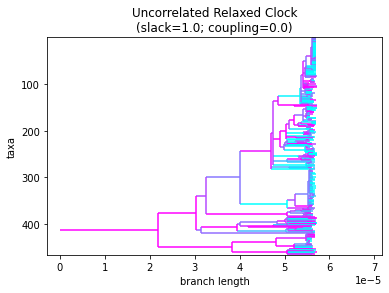

In [14]:
# draw trees inferred with the relaxed model
plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()

# Remove the outgroup
nodes_find_root = ["GCA_000323845.1_ASM32384v1_genomic","GCA_000323485.1_ASM32348v1_genomic","GCA_001972405.1_ASM197240v1_genomic"]

subtree = tt_relaxed.tree.common_ancestor(nodes_find_root)
for c in subtree.clades:
    if not c.is_terminal():
        subtree = c
        break

# Draw tree 
subtree.ladderize(reverse=True) # Flip upside down
Phylo.draw(subtree, axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

ax.set_title("Uncorrelated Relaxed Clock\n(slack=1.0; coupling=0.0)")
plt.savefig('uncorrelated-relaxed-clock_rate-variation.png', dpi=400, bbox_inches = "tight")

## Skyline

<Figure size 2400x1600 with 0 Axes>

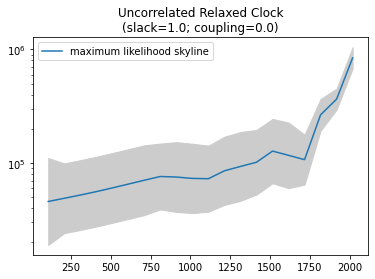

In [37]:
#plt.figure(dpi=400)
#x = wrappers.print_save_plot_skyline(tt_relaxed, n_std=2.0, screen=False)
skyline, conf = tt_relaxed.merger_model.skyline_inferred(gen=50, confidence=2)

plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()

plt.fill_between(skyline.x, conf[0], conf[1], color=(0.8, 0.8, 0.8))
plt.plot(skyline.x, skyline.y, label='maximum likelihood skyline')
plt.yscale('log')
plt.legend()
plt.ticklabel_format(axis='x',useOffset=False)

ax.set_title("Uncorrelated Relaxed Clock\n(slack=1.0; coupling=0.0)")

plt.savefig('uncorrelated-relaxed-clock_skyline.png', dpi=400)